In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Define constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Prepare data

Download data and save it

In [3]:
url = 'https://drive.google.com/file/d/1Bv0NmvbZ0Za9sxF0Zto7wxil_H_qSvnP/view?usp=sharing'

In [4]:
!gdown --id 1Bv0NmvbZ0Za9sxF0Zto7wxil_H_qSvnP

Downloading...
From: https://drive.google.com/uc?id=1Bv0NmvbZ0Za9sxF0Zto7wxil_H_qSvnP
To: /content/train.zip
570MB [00:02, 207MB/s]


Unzip and save into folder train_extracted

In [5]:
import zipfile
with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall("./train_extracted")

Exract labels from image names and save image names with corresponding labels in dataframe

In [6]:
filenames = os.listdir("./train_extracted/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1) # 1 for dog
    else:
        categories.append(0) # 0 for cat

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,dog.9287.jpg,1
1,cat.1246.jpg,0
2,dog.2877.jpg,1
3,cat.3931.jpg,0
4,cat.3317.jpg,0


In [8]:
df.tail()

,filename,category
24995,dog.3883.jpg,1
24996,cat.517.jpg,0
24997,cat.257.jpg,0
24998,cat.10261.jpg,0
24999,cat.9177.jpg,0


In [9]:
df.describe()

,category
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


Total count

In [10]:
label_counts = df.groupby('category').size()
print(label_counts)

category
0    12500
1    12500
dtype: int64


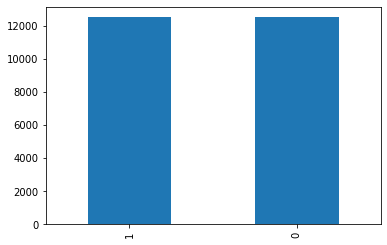

In [11]:
df['category'].value_counts().plot.bar()

Sample image

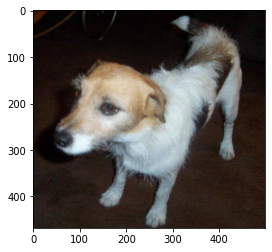

In [12]:
sample = random.choice(filenames)
image = load_img("./train_extracted/train/"+sample)
plt.imshow(image)

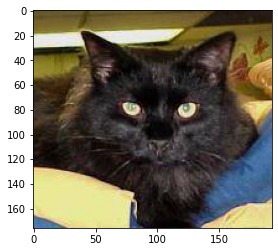

In [13]:
sample = random.choice(filenames)
image = load_img("./train_extracted/train/"+sample)
plt.imshow(image)

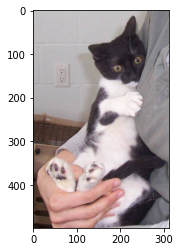

In [14]:
sample = random.choice(filenames)
image = load_img("./train_extracted/train/"+sample)
plt.imshow(image)

Build Model


Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.

Conv Layer: This layer will extract features from image.

Pooling Layer: This layerreduce the spatial volume of input image after convolution.

Fully Connected Layer: It connect the network from a layer to another layer

Output Layer: It is the predicted values layer.

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

Callbacks

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [17]:
earlystop = EarlyStopping(patience=10)

Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

Shuffle data frame

In [20]:
# shuffle the DataFrame rows 
df = df.sample(frac = 1).reset_index(drop=True) 

In [21]:
df.head()

,filename,category
0,dog.12043.jpg,1
1,cat.8298.jpg,0
2,cat.2101.jpg,0
3,cat.6521.jpg,0
4,dog.11530.jpg,1


In [22]:
df.tail()

,filename,category
24995,dog.2376.jpg,1
24996,cat.10333.jpg,0
24997,dog.8060.jpg,1
24998,dog.10416.jpg,1
24999,cat.3886.jpg,0


In [23]:
filenames = []
categories = []
for i in range(0, len(df)):
  filenames.append(str(df['filename'][i]))
  categories.append((df['category'][i]))
print(len(filenames))
print(len(categories))

25000
25000


In [24]:
print(filenames[0])
print(categories[0])
print(filenames[-1])
print(categories[-1])

dog.12043.jpg
1
cat.3886.jpg
0


Prepare data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [25]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [26]:
df.head()

,filename,category
0,dog.12043.jpg,dog
1,cat.8298.jpg,cat
2,cat.2101.jpg,cat
3,cat.6521.jpg,cat
4,dog.11530.jpg,dog


In [27]:
len(df['category'])

25000

Divide into 50% train and 50% test, Note that we have shuffled earlier

In [28]:
mid = int(len(df)/2)
df_train = df[:mid]
df_test = df[mid:].reset_index(drop=True)
print(len(df_train))
print(len(df_test))

12500
12500


In [29]:
train_df, validate_df = train_test_split(df_train, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

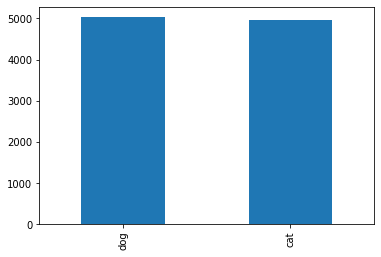

In [30]:
train_df['category'].value_counts().plot.bar()

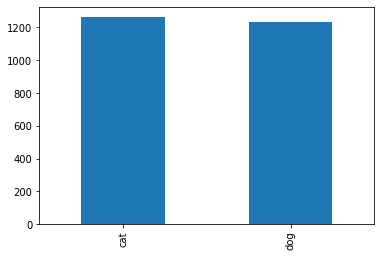

In [31]:
validate_df['category'].value_counts().plot.bar()

In [32]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Traning Generator

In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train_extracted/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 10000 validated image filenames belonging to 2 classes.


Validation Generator

In [34]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train_extracted/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


See how our generator work

In [35]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train_extracted/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


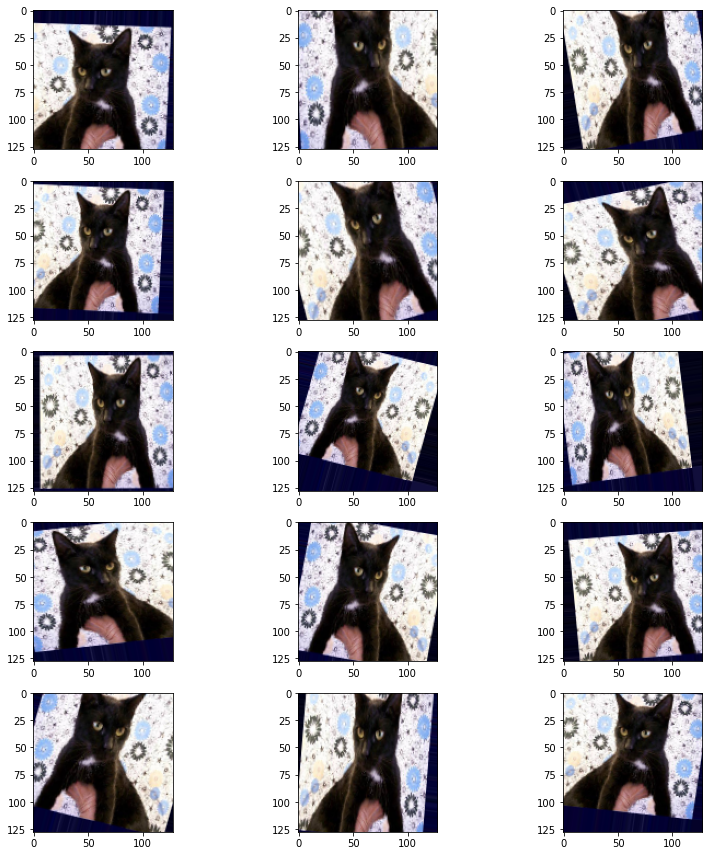

In [36]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seems great

Fit Model

In [37]:
FAST_RUN = False

In [38]:
epochs=3 if FAST_RUN else 15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
666/666 [==============================] - 66s 99ms/step - loss: 0.8716 - accuracy: 0.5914 - val_loss: 0.7220 - val_accuracy: 0.5269
Epoch 2/15
666/666 [==============================] - 66s 99ms/step - loss: 0.6253 - accuracy: 0.6687 - val_loss: 0.5718 - val_accuracy: 0.7028
Epoch 3/15
666/666 [==============================] - 66s 99ms/step - loss: 0.5624 - accuracy: 0.7205 - val_loss: 0.5634 - val_accuracy: 0.7257
Epoch 4/15
666/666 [==============================] - 66s 99ms/step - loss: 0.5216 - accuracy: 0.7443 - val_loss: 0.6192 - val_accuracy: 0.7028
Epoch 5/15
666/666 [==============================] - 66s 99ms/step - loss: 0.4840 - accuracy: 0.7739 - val_loss: 0.4887 - val_accuracy: 0.7687
Epoch 6/15
666/666 [==============================] - 66s 100ms/step - loss: 0.4516 - accuracy: 0.7913 - val_loss: 0.3801 - val_accuracy: 0.8249
Epoch 7/15
666/666 [==============================] - 68s 1

Save Model

In [39]:
model.save_weights("model.h5")

In [40]:
model.save_weights("Dogs_cats_50epochs_model.h5")

In [41]:
from google.colab import files
files.download('Dogs_cats_50epochs_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# saving the dataframe 
df.to_csv('df_CatsDogs.csv')
# saving the dataframe 
df_train.to_csv('df_train_CatsDogs.csv')
# saving the dataframe 
df_test.to_csv('df_test_CatsDogs.csv') 

In [43]:
files.download('df_CatsDogs.csv') 
files.download('df_train_CatsDogs.csv') 
files.download('df_test_CatsDogs.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


Visualize Training

Training loss and accuracy


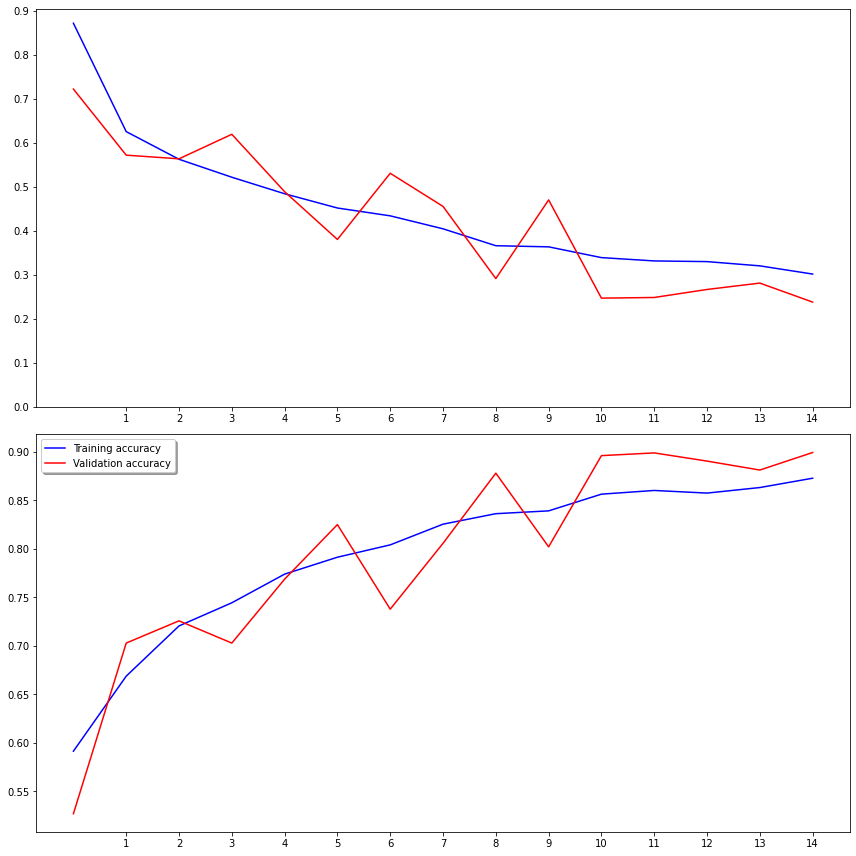

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
print("Training loss and accuracy")
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Prepare Testing Data

In [46]:
df_test.head()

,filename,category
0,dog.7884.jpg,dog
1,dog.5799.jpg,dog
2,dog.1960.jpg,dog
3,cat.2318.jpg,cat
4,cat.8052.jpg,cat


In [47]:
test_filenames = []
test_categories = []
for i in range(0,len(df_test)):
  test_filenames.append(df_test['filename'][i])
  test_categories.append(df_test['category'][i])
print(len(test_filenames))

12500


In [48]:
test_df = df_test
nb_samples = test_df.shape[0]

Create Testing Generator

In [49]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./train_extracted/train/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


Predict

In [50]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [51]:
print(predict)

[[0.08674925 0.91325074]
 [0.01616373 0.98383623]
 [0.09317664 0.9068234 ]
 ...
 [0.00976019 0.99023986]
 [0.00359108 0.9964089 ]
 [0.95135957 0.04864044]]


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [52]:
test_df['category_predicted'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [53]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category_predicted'] = test_df['category_predicted'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [54]:
test_df.head()

,filename,category,category_predicted
0,dog.7884.jpg,dog,dog
1,dog.5799.jpg,dog,dog
2,dog.1960.jpg,dog,dog
3,cat.2318.jpg,cat,cat
4,cat.8052.jpg,cat,cat


In [55]:
test_df['category_predicted'] = test_df['category_predicted'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Virtaulize Result

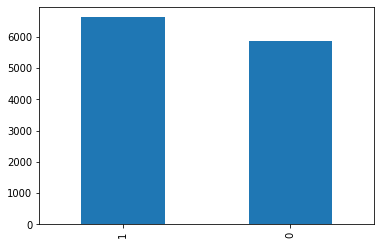

In [56]:
test_df['category_predicted'].value_counts().plot.bar()

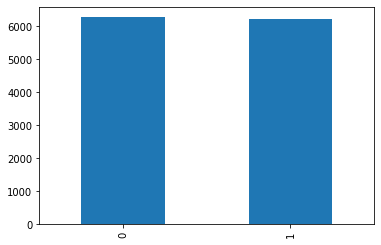

In [57]:
test_df['category'].value_counts().plot.bar()

In [58]:
test_df.head()

,filename,category,category_predicted
0,dog.7884.jpg,1,1
1,dog.5799.jpg,1,1
2,dog.1960.jpg,1,1
3,cat.2318.jpg,0,0
4,cat.8052.jpg,0,0


In [59]:
y_pred = test_df['category_predicted']
y_true = test_df['category']

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.90344

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[5471,  802],
       [ 405, 5822]])

In [62]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_true, y_pred))

0.8069225178240429


In [63]:
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more
target_names = ['Cat', 'Dog']
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

Classification Report:
               precision    recall  f1-score   support

         Cat       0.93      0.87      0.90      6273
         Dog       0.88      0.93      0.91      6227

    accuracy                           0.90     12500
   macro avg       0.91      0.90      0.90     12500
weighted avg       0.91      0.90      0.90     12500



See predicted result with images

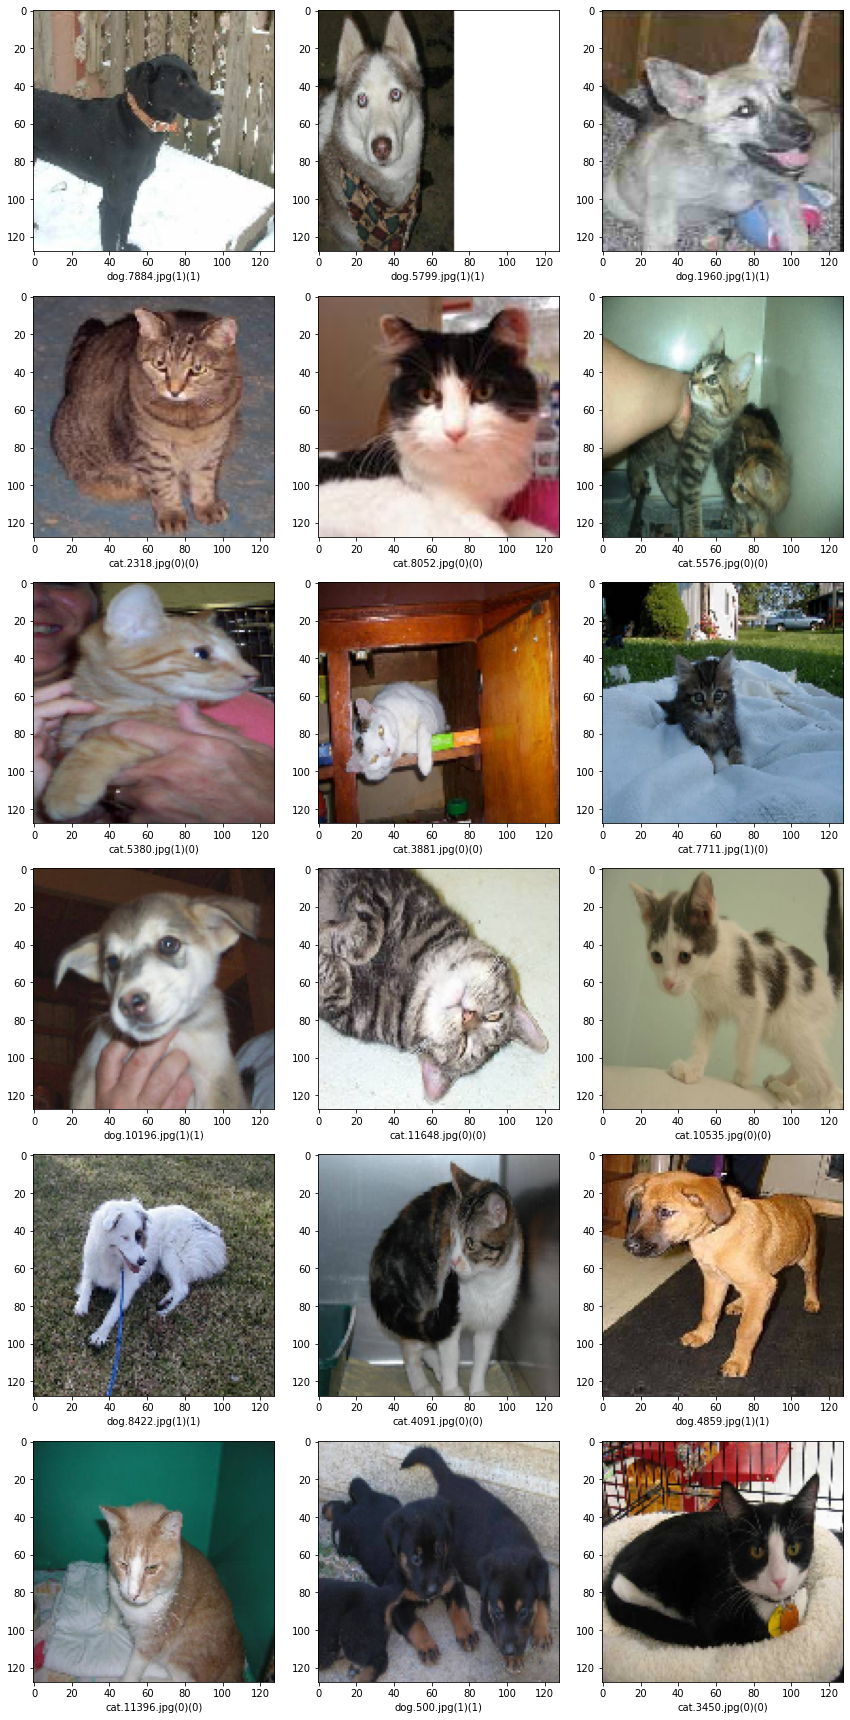

In [64]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    category_predicted = row['category_predicted']
    img = load_img("./train_extracted/train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category_predicted) + ')' + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [65]:
# saving the dataframe of our results
test_df.to_csv('test_df_Dogs_cats.csv') 
files.download('test_df_Dogs_cats.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>